In [1]:
# get a folder full of images whre the image-classifiers are wrong
# prepare VIT models
# compute alignment scores
# get spearman correlation 
# plot the correlation matrix

In [6]:
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed
from metrics import AlignmentMetrics
from tqdm import tqdm
import gc  # Garbage collector for memory management
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn.functional as F
import seaborn as sns

In [14]:
# -------------------- Initialization --------------------

EXPERIMENT_DIR = "places365/experiment_samples"
NOISE_STEPS_DIR = "noisy_images_steps"
os.makedirs(NOISE_STEPS_DIR, exist_ok=True)

FEATURES_DIR = "model_features"
os.makedirs(FEATURES_DIR, exist_ok=True)

# Load images from the experiment directory
image_files = os.listdir(EXPERIMENT_DIR)
image_files = sorted(image_files)  # Use all selected images, no shuffling or limiting

In [12]:
model_list = [
    "vit_tiny_patch16_224.augreg_in21k",
    "vit_small_patch16_224.augreg_in21k",
    "vit_base_patch16_224.augreg_in21k",
    "vit_large_patch16_224.augreg_in21k",
    "vit_base_patch16_224.mae",
    "vit_large_patch16_224.mae",
    "vit_huge_patch14_224.mae",
    "vit_small_patch14_dinov2.lvd142m",
    "vit_base_patch14_dinov2.lvd142m",
    "vit_large_patch14_dinov2.lvd142m",
    "vit_giant_patch14_dinov2.lvd142m",
    "vit_base_patch16_clip_224.laion2b",
    "vit_large_patch14_clip_224.laion2b",
    "vit_huge_patch14_clip_224.laion2b",
    "vit_base_patch16_clip_224.laion2b_ft_in12k",
    "vit_large_patch14_clip_224.laion2b_ft_in12k",
    "vit_huge_patch14_clip_224.laion2b_ft_in12k",
]


In [15]:
# -------------------- Image Loading --------------------

def load_image_as_array(image_path):
    """Load an image, convert to RGB, and return as a NumPy array normalized to [0, 1]."""
    try:
        with Image.open(image_path) as img:
            img = img.convert("RGB")
            img_array = np.array(img) / 255.0  # Normalize to [0, 1]
            return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Load all images as NumPy arrays
loaded_images = [load_image_as_array(os.path.join(EXPERIMENT_DIR, img_file)) for img_file in image_files]
loaded_images = [img for img in loaded_images if img is not None]

# --------

In [ ]:
------------ Noise Addition Function --------------------

def save_noisy_images_step(images, step, total_steps):
    """Blend images with random noise and save them in a folder named after the noise step."""
    alpha = step / total_steps  # Blending factor, increases linearly
    step_dir = os.path.join(NOISE_STEPS_DIR, f"step_{step:03d}")
    os.makedirs(step_dir, exist_ok=True)
    
    for idx, img in enumerate(images):
        random_noise = np.random.rand(*img.shape)  # Random noise image
        noisy_image = (1 - alpha) * img + alpha * random_noise
        noisy_image = np.clip(noisy_image, 0, 1)  # Ensure values remain in [0, 1]
        noisy_image_pil = Image.fromarray((noisy_image * 255).astype('uint8'))
        noisy_image_pil.save(os.path.join(step_dir, f"image_{idx:04d}.png"))

# Parallel noise addition and saving
total_steps = 100
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(save_noisy_images_step, loaded_images, step, total_steps) for step in range(total_steps)]
    for future in tqdm(as_completed(futures), total=total_steps, desc="Adding noise to images"):
        future.result()  # Will raise any exceptions caught during the execution

In [20]:
############################### alignment calculation ############################3

In [21]:


# -------------------- Setup Logging --------------------

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.FileHandler("feature_extraction.log"),
        logging.StreamHandler()
    ]
)

# -------------------- Helper Functions --------------------

def get_dynamic_settings(model_name, input_size, gpu_memory_gb=24):
    """
    Adjust batch size based on model size and input size to fit within GPU memory constraints.
    """
    # Define keywords to categorize models
    large_models = ["vit_large", "vit_huge", "vit_giant", "dinov2", "clip"]
    medium_models = ["vit_base"]
    small_models = ["vit_small", "vit_tiny"]

    # Default batch size
    batch_size = 32

    # Adjust batch size based on model size
    if any(keyword in model_name for keyword in large_models):
        batch_size = 8  # Further reduced for very large models
    elif any(keyword in model_name for keyword in medium_models):
        batch_size = 16
    elif any(keyword in model_name for keyword in small_models):
        batch_size = 32
    else:
        batch_size = 16  # Fallback batch size

    # Further adjust based on input size if needed
    if max(input_size) > 224:
        batch_size = max(4, batch_size // 2)  # Example adjustment for larger inputs

    return batch_size

def extract_features(model, images, batch_size=32):
    """
    Extract CLS token features from a model for given images using mixed precision.
    """
    features = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.cuda.amp.autocast():
        with torch.no_grad():
            for i in range(0, len(images), batch_size):
                try:
                    batch = torch.stack(images[i:i + batch_size]).to(device)
                except Exception as e:
                    logging.error(f"Error stacking batch {i} to {i + batch_size}: {e}")
                    continue

                try:
                    outputs = model.forward_features(batch)
                    cls_tokens = F.normalize(outputs[:, 0, :], dim=-1)
                    features.append(cls_tokens.cpu())  # Move to CPU to save GPU memory
                except Exception as e:
                    logging.error(f"Error extracting features for batch {i} to {i + batch_size}: {e}")
                    continue

    if features:
        features = torch.cat(features, dim=0)
    else:
        features = torch.tensor([])  # Return empty tensor if no features extracted

    return features

def load_images_from_step(step_dir, target_size=(224, 224)):
    """
    Load all images from a given noise step directory and resize them to the target size.
    """
    supported_formats = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    try:
        image_files = sorted([f for f in os.listdir(step_dir) if f.lower().endswith(supported_formats)])
    except Exception as e:
        logging.error(f"Error listing files in directory {step_dir}: {e}")
        return []

    images = []
    for img_file in image_files:
        img_path = os.path.join(step_dir, img_file)
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB").resize(target_size, Image.BILINEAR)  # Resize to target size
                img_tensor = torch.tensor(np.array(img) / 255.0, dtype=torch.float32).permute(2, 0, 1)  # Convert to tensor
                images.append(img_tensor)
        except Exception as e:
            logging.warning(f"Error loading image {img_path}: {e}")
    return images

def extract_features_for_step(model, step_dir, step, batch_size=32):
    """
    Extract features for a given model and noise step.
    """
    images = load_images_from_step(step_dir)
    if not images:
        raise ValueError(f"No images found in {step_dir}")

    features = extract_features(model, images, batch_size)
    del images  # Free up memory used by images
    torch.cuda.empty_cache()  # Clear any remaining GPU cache
    gc.collect()  # Trigger garbage collection
    return step, features

def process_model(model_name, steps_to_process, NOISE_STEPS_DIR, gpu_memory_gb=24, model_input_sizes=None):
    """
    Process feature extraction for a model across specified steps.
    """
    logging.info(f"Processing model: {model_name}")
    noise_features = {}
    feature_save_path = f"{model_name}_features.pt"

    # Check if features for this model are already saved
    if os.path.exists(feature_save_path):
        logging.info(f"Loading saved features for {model_name} from {feature_save_path}...")
        try:
            noise_features = torch.load(feature_save_path)
            logging.info(f"Loaded features for {model_name} successfully.")
            return noise_features
        except Exception as e:
            logging.error(f"Error loading saved features for {model_name}: {e}")
            # Proceed to re-process the model
            noise_features = {}

    try:
        # Initialize the model
        logging.info(f"Initializing model {model_name}...")
        model = timm.create_model(model_name, pretrained=True)
        logging.info(f"Model {model_name} initialized successfully.")

        # Get the model's input size
        input_size = model.default_cfg.get('input_size', (3, 224, 224))
        if model_input_sizes and model_name in model_input_sizes:
            height, width = model_input_sizes[model_name]
            logging.info(f"Overriding input size for {model_name} to ({height}, {width}) as per predefined mapping.")
        elif isinstance(input_size, (list, tuple)) and len(input_size) == 3:
            _, height, width = input_size
        else:
            height, width = 224, 224  # Default fallback
        logging.info(f"Model {model_name} expects input size: ({height}, {width})")

        # Adjust batch size based on model size and input size
        batch_size = get_dynamic_settings(model_name, height)
        logging.info(f"Using batch size: {batch_size} for model {model_name}")

        for step in steps_to_process:
            step_dir = os.path.join(NOISE_STEPS_DIR, f"step_{step:03d}")
            if not os.path.isdir(step_dir):
                logging.warning(f"Directory {step_dir} does not exist. Skipping step {step}.")
                continue
            try:
                step_num, features = extract_features_for_step(model, step_dir, step, batch_size)
                noise_features[step_num] = features
                torch.save(noise_features, feature_save_path)  # Save incrementally
                logging.info(f"Saved features for model {model_name}, step {step_num}.")
            except Exception as e:
                logging.error(f"Error processing step {step} for model {model_name}: {e}")

    except Exception as e:
        logging.error(f"Error initializing model {model_name}: {e}")
    finally:
        # Ensure model is deleted and memory is freed
        if 'model' in locals():
            del model
            torch.cuda.empty_cache()
            gc.collect()
            logging.info(f"Cleared GPU memory after processing model {model_name}.")

    return noise_features

def compute_alignment_scores(model_features_noise, model_list, steps_to_process):
    """
    Calculate alignment scores between all pairs of models at different noise levels.
    """
    alignment_records = []

    # Calculate alignment scores at different noise levels
    for step in steps_to_process:
        for model_a, model_b in itertools.combinations(model_list, 2):
            try:
                features_a = model_features_noise[model_a][step]
                features_b = model_features_noise[model_b][step]
                score = AlignmentMetrics.mutual_knn(features_a, features_b, topk=50)

                alignment_records.append({
                    'Model A': model_a,
                    'Model B': model_b,
                    'Step': step,
                    'Score': score
                })
            except KeyError as ke:
                logging.warning(f"Missing features for step {step}: {ke}")
            except Exception as e:
                logging.error(f"Error calculating alignment score for models {model_a} and {model_b} at step {step}: {e}")

    # Create DataFrame from results
    score_df = pd.DataFrame(alignment_records)
    return score_df

def plot_results(score_df):
    """
    Plot alignment scores as noise increases.
    """
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=score_df, x='Step', y='Score', hue='Model A', style='Model B', markers=True)
    plt.title('Alignment Score (mutual_knn) vs. Noise Level')
    plt.xlabel('Noise Step (0 = original, 100 = random noise)')
    plt.ylabel('Alignment Score')
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# -------------------- Main Execution --------------------

Processing models:   0%|                                                                                             | 0/17 [00:00<?, ?it/s]2024-10-24 00:12:37,714 [INFO] Processing model: vit_tiny_patch16_224.augreg_in21k
2024-10-24 00:12:37,714 [INFO] Loading saved features for vit_tiny_patch16_224.augreg_in21k from vit_tiny_patch16_224.augreg_in21k_features.pt...
/tmp/ipykernel_37642/1971613063.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are expli

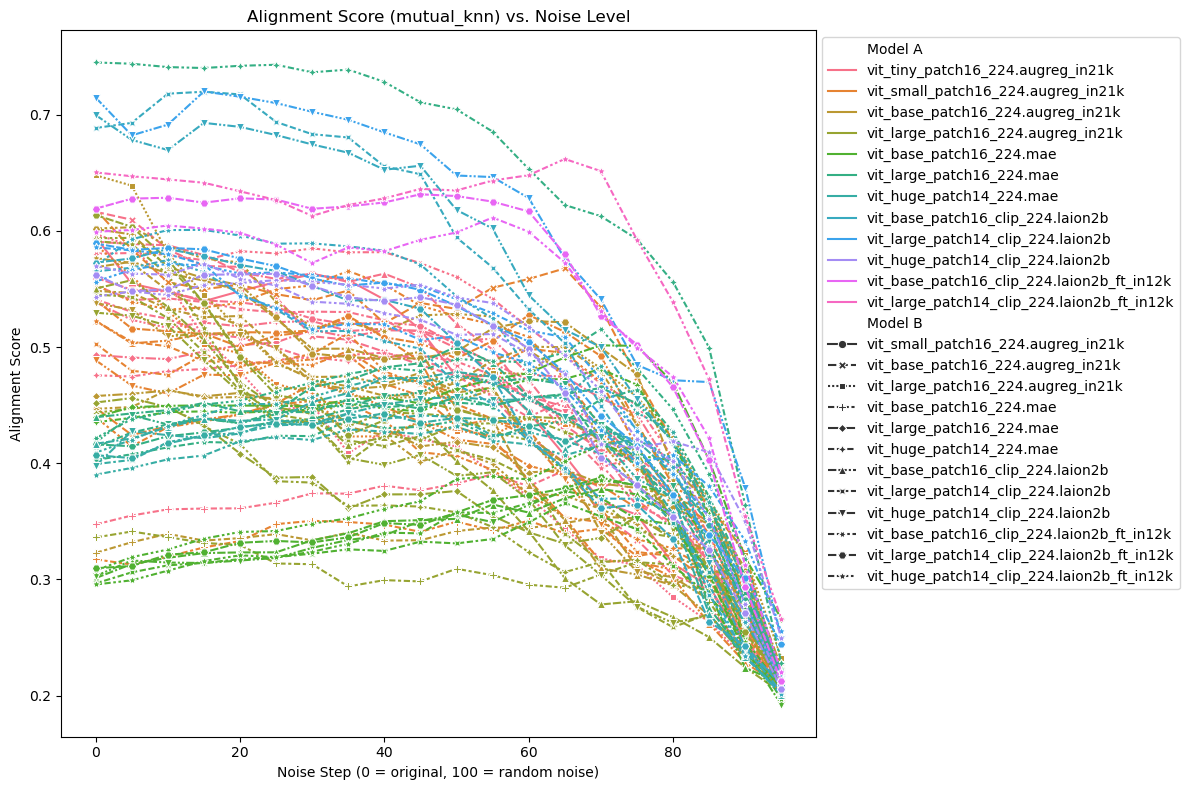

2024-10-24 00:13:08,249 [INFO] Feature extraction and alignment computation completed successfully.
2024-10-24 00:13:08,249 [INFO] Model vit_tiny_patch16_224.augreg_in21k has features for all steps.
2024-10-24 00:13:08,250 [INFO] Model vit_small_patch16_224.augreg_in21k has features for all steps.
2024-10-24 00:13:08,251 [INFO] Model vit_base_patch16_224.augreg_in21k has features for all steps.
2024-10-24 00:13:08,251 [INFO] Model vit_large_patch16_224.augreg_in21k has features for all steps.
2024-10-24 00:13:08,252 [INFO] Model vit_base_patch16_224.mae has features for all steps.
2024-10-24 00:13:08,252 [INFO] Model vit_large_patch16_224.mae has features for all steps.
2024-10-24 00:13:08,252 [INFO] Model vit_huge_patch14_224.mae has features for all steps.
2024-10-24 00:13:08,253 [WARNING] Model vit_small_patch14_dinov2.lvd142m is missing features for steps: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
2024-10-24 00:13:08,253 [WARNING] Model vit_base

In [22]:
gpu_memory_gb = 24  # GPU memory in GB
steps_to_process = range(0, 100, 5)  # Process steps with an interval of 5 (0, 5, 10, ..., 95)

# Define a mapping of model names to their expected input sizes if they deviate from default
model_input_sizes = {
    "vit_small_patch14_dinov2.lvd142m": (518, 518),
    "vit_base_patch14_dinov2.lvd142m": (518, 518),
    "vit_large_patch14_dinov2.lvd142m": (518, 518),
    "vit_giant_patch14_dinov2.lvd142m": (518, 518),
    # Add other models with custom input sizes here if needed
}

# Check available models in timm
available_models = set(timm.list_models(pretrained=True))
missing_models = [model for model in model_list if model not in available_models]
if missing_models:
    logging.warning(f"The following models are not available in timm and will be skipped: {missing_models}")
    # Remove missing models from the list
    model_list = [model for model in model_list if model in available_models]

model_features_noise = {}

# Initialize a single tqdm progress bar for model processing
for model_name in tqdm(model_list, desc="Processing models"):
    features = process_model(
        model_name=model_name,
        steps_to_process=steps_to_process,
        NOISE_STEPS_DIR=NOISE_STEPS_DIR,
        gpu_memory_gb=gpu_memory_gb,
        model_input_sizes=model_input_sizes
    )
    model_features_noise[model_name] = features

# -------------------- Alignment Metric Computation --------------------

score_df = compute_alignment_scores(model_features_noise, model_list, steps_to_process)

# -------------------- Plotting the Results --------------------

plot_results(score_df)
logging.info("Feature extraction and alignment computation completed successfully.")

# -------------------- Verification of All Features --------------------

expected_steps = set(steps_to_process)
for model_name in model_list:
    available_steps = set(model_features_noise.get(model_name, {}).keys())
    missing_steps = expected_steps - available_steps
    if missing_steps:
        logging.warning(f"Model {model_name} is missing features for steps: {sorted(missing_steps)}")
    else:
        logging.info(f"Model {model_name} has features for all steps.")


In [25]:
score_df.to_csv("alignment_scores.csv")

In [38]:
plot_results(score_df)

2024-10-24 00:26:10,604 [INFO] Main alignment plot saved as 'alignment_plot.png'.
2024-10-24 00:26:12,211 [INFO] Legend saved as 'legend.png'.


In [28]:
score_df.head()

,Model A,Model B,Step,Score
0,vit_tiny_patch16_224.augreg_in21k,vit_small_patch16_224.augreg_in21k,0,0.59448
1,vit_tiny_patch16_224.augreg_in21k,vit_base_patch16_224.augreg_in21k,0,0.61640
2,vit_tiny_patch16_224.augreg_in21k,vit_large_patch16_224.augreg_in21k,0,0.59712
3,vit_tiny_patch16_224.augreg_in21k,vit_base_patch16_224.mae,0,0.34736
4,vit_tiny_patch16_224.augreg_in21k,vit_large_patch16_224.mae,0,0.49304


In [29]:
score_df['Model Pair'] = score_df['Model A'] + " vs " + score_df['Model B']

In [30]:

def plot_results(score_df):
    """
    Plot alignment scores as noise increases using 'Model Pair' for hue.
    """
    plt.figure(figsize=(14, 10))
    
    # Create a line plot with 'Step' on the x-axis, 'Score' on the y-axis, and 'Model Pair' as hue
    sns.lineplot(
        data=score_df,
        x='Step',
        y='Score',
        hue='Model Pair',
        palette='tab20',  # You can choose a different palette if needed
        marker='o'
    )
    
    plt.title('Alignment Score (mutual_knn) vs. Noise Level', fontsize=16)
    plt.xlabel('Noise Step (0 = original, 100 = random noise)', fontsize=14)
    plt.ylabel('Alignment Score', fontsize=14)
    plt.legend(title='Model Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [32]:
def plot_results_facet(score_df):
    """
    Plot alignment scores using FacetGrid to handle multiple model pairs.
    """
    g = sns.FacetGrid(score_df, col="Model Pair", col_wrap=4, height=3, sharex=True, sharey=True)
    g.map_dataframe(sns.lineplot, x='Step', y='Score', marker='o')
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Noise Step", "Alignment Score")
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle('Alignment Score (mutual_knn) vs. Noise Level for Each Model Pair', fontsize=16)
    plt.show()


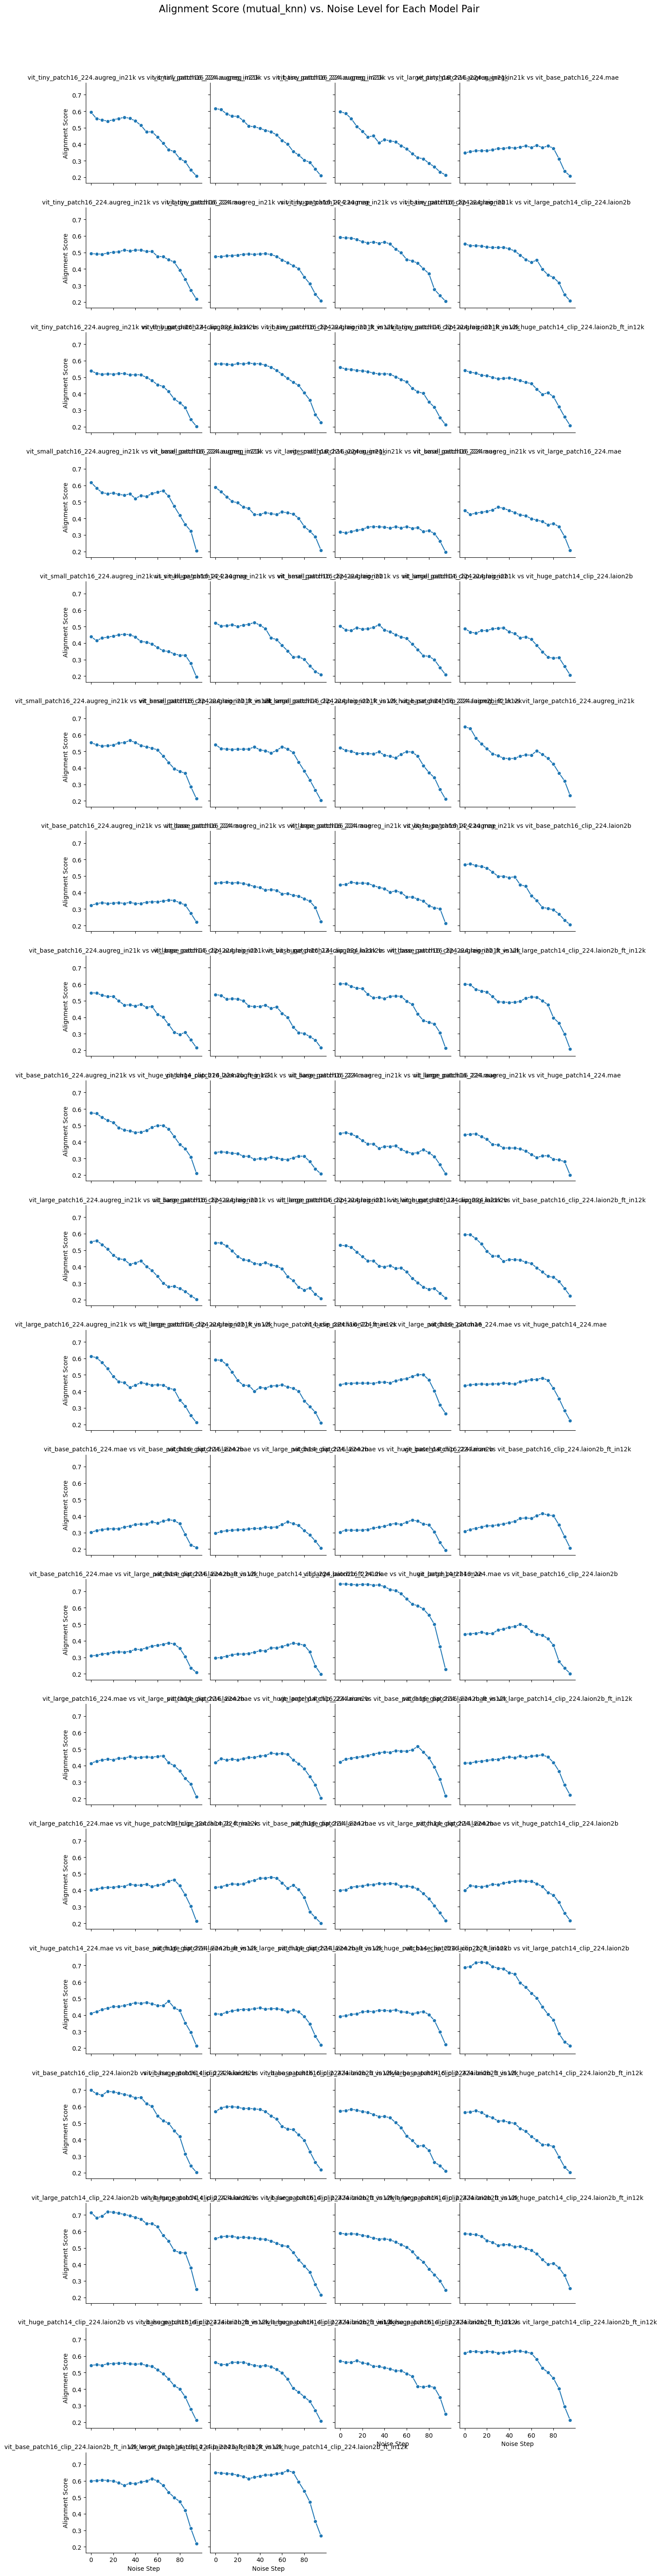

In [33]:
plot_results_facet(score_df)

In [2]:
score_df = pd.read_csv("alignment_scores.csv")

In [3]:
score_df.head()

,Unnamed: 0,Model A,Model B,Step,Score
0,0,vit_tiny_patch16_224.augreg_in21k,vit_small_patch16_224.augreg_in21k,0,0.59448
1,1,vit_tiny_patch16_224.augreg_in21k,vit_base_patch16_224.augreg_in21k,0,0.61640
2,2,vit_tiny_patch16_224.augreg_in21k,vit_large_patch16_224.augreg_in21k,0,0.59712
3,3,vit_tiny_patch16_224.augreg_in21k,vit_base_patch16_224.mae,0,0.34736
4,4,vit_tiny_patch16_224.augreg_in21k,vit_large_patch16_224.mae,0,0.49304


In [7]:
# Total steps for noise addition
total_steps = 100

# Create a dictionary mapping each step to its corresponding noise level (alpha)
noise_levels_dict = {step: step / total_steps for step in range(total_steps + 1)}

# Display the noise levels dictionary
print("\nNoise Levels Dictionary:")
print(noise_levels_dict)



Noise Levels Dictionary:
{0: 0.0, 1: 0.01, 2: 0.02, 3: 0.03, 4: 0.04, 5: 0.05, 6: 0.06, 7: 0.07, 8: 0.08, 9: 0.09, 10: 0.1, 11: 0.11, 12: 0.12, 13: 0.13, 14: 0.14, 15: 0.15, 16: 0.16, 17: 0.17, 18: 0.18, 19: 0.19, 20: 0.2, 21: 0.21, 22: 0.22, 23: 0.23, 24: 0.24, 25: 0.25, 26: 0.26, 27: 0.27, 28: 0.28, 29: 0.29, 30: 0.3, 31: 0.31, 32: 0.32, 33: 0.33, 34: 0.34, 35: 0.35, 36: 0.36, 37: 0.37, 38: 0.38, 39: 0.39, 40: 0.4, 41: 0.41, 42: 0.42, 43: 0.43, 44: 0.44, 45: 0.45, 46: 0.46, 47: 0.47, 48: 0.48, 49: 0.49, 50: 0.5, 51: 0.51, 52: 0.52, 53: 0.53, 54: 0.54, 55: 0.55, 56: 0.56, 57: 0.57, 58: 0.58, 59: 0.59, 60: 0.6, 61: 0.61, 62: 0.62, 63: 0.63, 64: 0.64, 65: 0.65, 66: 0.66, 67: 0.67, 68: 0.68, 69: 0.69, 70: 0.7, 71: 0.71, 72: 0.72, 73: 0.73, 74: 0.74, 75: 0.75, 76: 0.76, 77: 0.77, 78: 0.78, 79: 0.79, 80: 0.8, 81: 0.81, 82: 0.82, 83: 0.83, 84: 0.84, 85: 0.85, 86: 0.86, 87: 0.87, 88: 0.88, 89: 0.89, 90: 0.9, 91: 0.91, 92: 0.92, 93: 0.93, 94: 0.94, 95: 0.95, 96: 0.96, 97: 0.97, 98: 0.98, 99:

Sample of the data:
   Unnamed: 0                            Model A  \
0           0  vit_tiny_patch16_224.augreg_in21k   
1           1  vit_tiny_patch16_224.augreg_in21k   
2           2  vit_tiny_patch16_224.augreg_in21k   
3           3  vit_tiny_patch16_224.augreg_in21k   
4           4  vit_tiny_patch16_224.augreg_in21k   

                              Model B  Step    Score  
0  vit_small_patch16_224.augreg_in21k     0  0.59448  
1   vit_base_patch16_224.augreg_in21k     0  0.61640  
2  vit_large_patch16_224.augreg_in21k     0  0.59712  
3            vit_base_patch16_224.mae     0  0.34736  
4           vit_large_patch16_224.mae     0  0.49304  

Mean alignment scores at each step:
    Step     Score
0      0  0.505711
1      5  0.503208
2     10  0.500117
3     15  0.496359
4     20  0.490928
5     25  0.484844
6     30  0.481440
7     35  0.478751
8     40  0.476744
9     45  0.474392
10    50  0.467807
11    55  0.462256
12    60  0.449019
13    65  0.435757
14    70  0.417

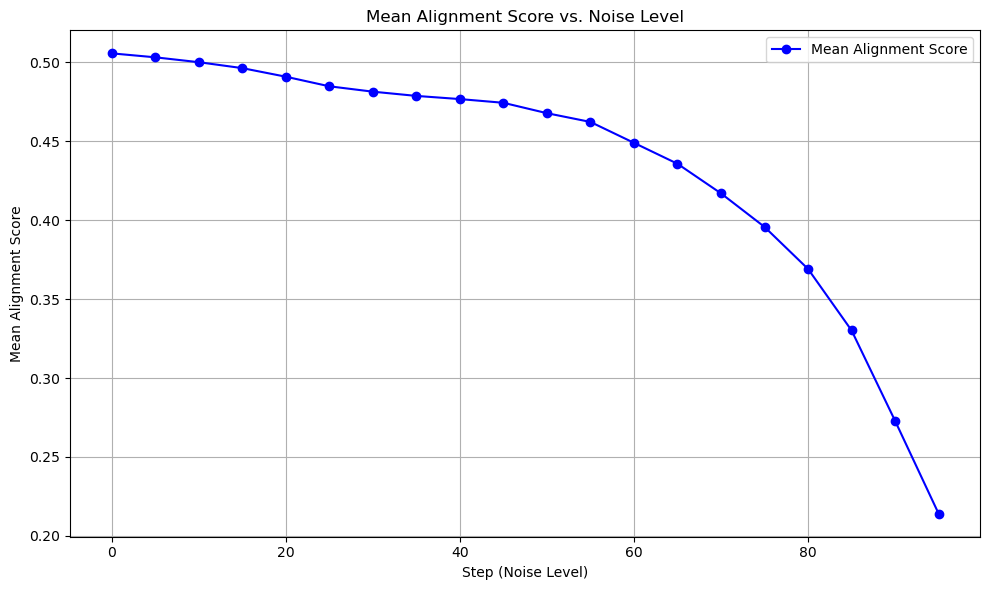

In [4]:


# Load the alignment scores from the CSV file
# Replace 'alignment_scores.csv' with the path to your CSV file
df = pd.read_csv('alignment_scores.csv')

# Display the first few rows to understand the structure
print("Sample of the data:")
print(df.head())

# Calculate the mean score for each step
mean_scores = df.groupby('Step')['Score'].mean().reset_index()

# Display the calculated mean scores
print("\nMean alignment scores at each step:")
print(mean_scores)

# Plot the mean scores over different steps
plt.figure(figsize=(10, 6))
plt.plot(mean_scores['Step'], mean_scores['Score'], marker='o', linestyle='-', color='b', label='Mean Alignment Score')
plt.xlabel('Step (Noise Level)')
plt.ylabel('Mean Alignment Score')
plt.title('Mean Alignment Score vs. Noise Level')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Mean alignment scores at each signal level:
    Signal Level     Score
0           0.05  0.214077
1           0.10  0.272866
2           0.15  0.330157
3           0.20  0.369113
4           0.25  0.395748
5           0.30  0.417001
6           0.35  0.435757
7           0.40  0.449019
8           0.45  0.462256
9           0.50  0.467807
10          0.55  0.474392
11          0.60  0.476744
12          0.65  0.478751
13          0.70  0.481440
14          0.75  0.484844
15          0.80  0.490928
16          0.85  0.496359
17          0.90  0.500117
18          0.95  0.503208
19          1.00  0.505711


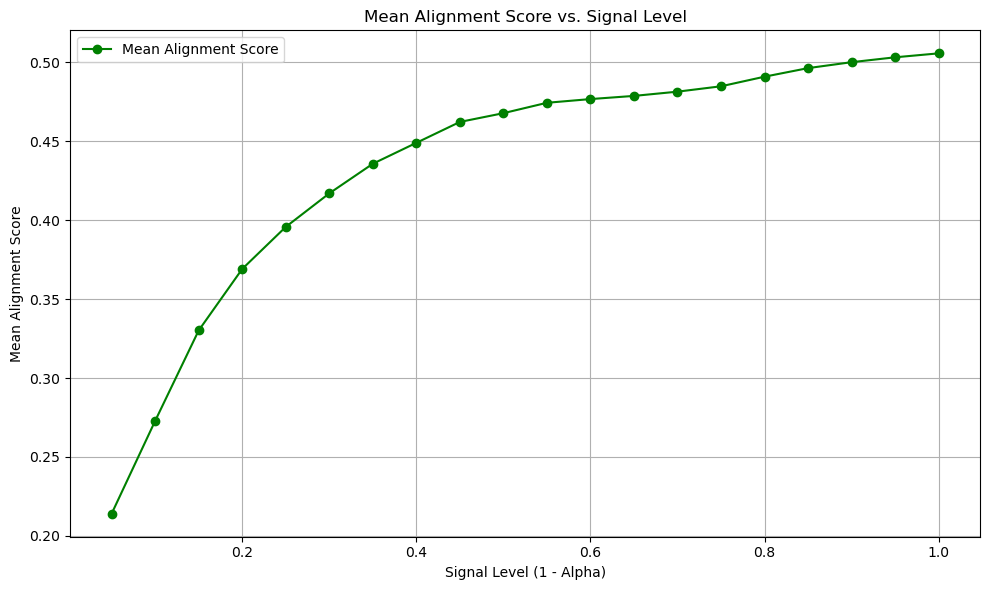

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the alignment scores from the CSV file
# Replace 'alignment_scores.csv' with the path to your CSV file
df = pd.read_csv('alignment_scores.csv')

# Assume 'noise_levels_dict' is available and maps step to noise level
# Example: noise_levels_dict = {0: 0.0, 1: 0.01, ..., 100: 1.0}

# Map each step to its corresponding noise level in the DataFrame
df['Noise Level'] = df['Step'].map(noise_levels_dict)

# Calculate the signal level as (1 - Noise Level)
df['Signal Level'] = 1 - df['Noise Level']

# Calculate the mean score for each signal level
mean_scores_signal = df.groupby('Signal Level')['Score'].mean().reset_index()

# Display the calculated mean scores for each signal level
print("\nMean alignment scores at each signal level:")
print(mean_scores_signal)

# Plot the mean scores over different signal levels
plt.figure(figsize=(10, 6))
plt.plot(mean_scores_signal['Signal Level'], mean_scores_signal['Score'], marker='o', linestyle='-', color='g', label='Mean Alignment Score')
plt.xlabel('Signal Level (1 - Alpha)')
plt.ylabel('Mean Alignment Score')
plt.title('Mean Alignment Score vs. Signal Level')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
import os
import pandas as pd
import torch
import logging
from scipy.stats import entropy
from scipy.spatial.distance import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import itertools

# -------------------- Configuration --------------------

FEATURES_DIR = "model_features"
model_list = [
    "vit_tiny_patch16_224.augreg_in21k",
    "vit_small_patch16_224.augreg_in21k",
    "vit_base_patch16_224.augreg_in21k",
    "vit_large_patch16_224.augreg_in21k",
    "vit_base_patch16_224.mae",
    "vit_large_patch16_224.mae",
    "vit_huge_patch14_224.mae",
    "vit_small_patch14_dinov2.lvd142m",
    "vit_base_patch14_dinov2.lvd142m",
    "vit_large_patch14_dinov2.lvd142m",
    "vit_giant_patch14_dinov2.lvd142m",
    "vit_base_patch16_clip_224.laion2b",
    "vit_large_patch14_clip_224.laion2b",
    "vit_huge_patch14_clip_224.laion2b",
    "vit_base_patch16_clip_224.laion2b_ft_in12k",
    "vit_large_patch14_clip_224.laion2b_ft_in12k",
    "vit_huge_patch14_clip_224.laion2b_ft_in12k",
]
steps_to_process = range(0, 101, 5)  # Assume steps from 0 to 100 with an interval of 5
total_steps = 100
noise_levels_dict = {step: step / total_steps for step in range(total_steps + 1)}

# -------------------- Helper Functions --------------------

def load_precomputed_features(model_name, step):
    """Load precomputed features for a given model and step."""
    feature_path = os.path.join(FEATURES_DIR, f"{model_name}_step_{step}.pt")
    if os.path.exists(feature_path):
        return torch.load(feature_path)
    else:
        logging.warning(f"Features not found for {model_name} at step {step}.")
        return None

def compute_divergences(model_features, model_a, model_b, step):
    """Compute KL divergence and Wasserstein distance between two feature sets."""
    try:
        features_a = model_features[model_a][step].numpy()
        features_b = model_features[model_b][step].numpy()

        # Calculate KL divergence
        kl_div = entropy(features_a.flatten(), features_b.flatten())

        # Calculate Wasserstein distance
        wass_dist = wasserstein_distance(features_a.flatten(), features_b.flatten())

        return {
            'Model A': model_a,
            'Model B': model_b,
            'Step': step,
            'Noise Level': noise_levels_dict[step],
            'KL Divergence': kl_div,
            'Wasserstein Distance': wass_dist
        }
    except Exception as e:
        logging.error(f"Error computing divergences for {model_a} vs {model_b} at step {step}: {e}")
        return None

# -------------------- Load Precomputed Features --------------------

# Load all features into a dictionary
model_features = {model_name: {} for model_name in model_list}

for model_name in tqdm(model_list, desc="Loading precomputed features"):
    for step in steps_to_process:
        features = load_precomputed_features(model_name, step)
        if features is not None:
            model_features[model_name][step] = features

# -------------------- Compute Divergence Measures --------------------

divergence_records = []

with ThreadPoolExecutor() as executor:
    futures = []
    for step in steps_to_process:
        for model_a, model_b in itertools.combinations(model_list, 2):
            futures.append(
                executor.submit(compute_divergences, model_features, model_a, model_b, step)
            )

    for future in tqdm(as_completed(futures), total=len(futures), desc="Calculating divergences"):
        result = future.result()
        if result is not None:
            divergence_records.append(result)

# Create DataFrame from divergence records
divergence_df = pd.DataFrame(divergence_records)
divergence_df.to_csv("divergence_scores.csv", index=False)

# -------------------- Plotting Divergence Results --------------------

def plot_divergence(df, metric):
    """Plot divergence as noise increases."""
    df['Model Pair'] = df['Model A'] + " vs " + df['Model B']
    plt.figure(figsize=(14, 10))
    sns.lineplot(data=df, x='Noise Level', y=metric, hue='Model Pair', marker='o')
    plt.title(f'{metric} vs. Noise Level')
    plt.xlabel('Noise Level')
    plt.ylabel(metric)
    plt.legend(title='Model Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_divergence(divergence_df, 'KL Divergence')
plot_divergence(divergence_df, 'Wasserstein Distance')


ImportError: cannot import name 'wasserstein_distance' from 'scipy.spatial.distance' (/home/oppenheimer/anaconda3/lib/python3.12/site-packages/scipy/spatial/distance.py)